Clean model maker


In [1]:
#imports
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.metrics # import Precision, Recall,Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from sklearn.metrics import classification_report

# Set parameters

In [2]:
#for data splits
batch_size = 16 #None = 1 #16 #32
img_height = 224
img_width = 224
seed_train_validation = 69 # Must be same for train_ds and val_ds
#shuffle_value = True
#validation_split = 0.2 irrelevant


In [3]:
new_way = True
label_mode = "int" 

def load_data_new_way():
    #path_to_dataset = os.path.join("..", "test_data", "3_test_from_bucket2")
    
    path_to_dataset = os.path.join("..","..","data","food")
    
    #path_to_dataset = os.path.join("..", "..", "test_data", "3_whole_bucket_no_aug")
    
    path_to_dataset_train = os.path.join(path_to_dataset, "train")
    path_to_dataset_test = os.path.join(path_to_dataset,  "test")
    path_to_dataset_val = os.path.join(path_to_dataset,   "val")
    
    X_train = image_dataset_from_directory(
        path_to_dataset_train,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
        )

    X_val = image_dataset_from_directory(
        path_to_dataset_val,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
        )

    X_test = image_dataset_from_directory(
        path_to_dataset_test,
        label_mode=label_mode,
        color_mode="rgb",
        seed=seed_train_validation,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=False
        )
    return X_train,X_val,X_test
X_train, X_val, X_test = load_data_new_way()

#print sample label

Found 45633 files belonging to 45 classes.
Found 9198 files belonging to 45 classes.
Found 9209 files belonging to 45 classes.


In [4]:
X_train.class_names

['apple',
 'asparagus',
 'avocado',
 'banana',
 'beef',
 'beetroot',
 'blueberry',
 'broccoli',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'celery',
 'chicken',
 'coconut',
 'cod',
 'corn',
 'cranberry',
 'cucumber',
 'eggplant',
 'eggs',
 'garlic',
 'ginger',
 'grape',
 'honey',
 'kiwi',
 'leek',
 'lemon',
 'lettuce',
 'lime',
 'milk',
 'mushroom',
 'onion',
 'orange',
 'pineapple',
 'pork',
 'potato',
 'prawns',
 'pumpkin',
 'salmon',
 'spinach',
 'strawberry',
 'tomato',
 'white_wine',
 'zucchini']

In [5]:
train_batches = tf.data.experimental.cardinality(X_train)
test_batches = tf.data.experimental.cardinality(X_test)
val_batches = tf.data.experimental.cardinality(X_val)

train_batches.numpy() , test_batches.numpy() ,val_batches.numpy()

(2853, 576, 575)

In [6]:
X_val


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Prep for model

In [7]:
def get_target_dict():
    #classes = os.listdir(path_to_dataset_test)
    classes = X_test.class_names
    classes.sort()
    
    #classes.remove(".ipynb_checkpoints")
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict

{0: 'apple',
 1: 'asparagus',
 2: 'avocado',
 3: 'banana',
 4: 'beef',
 5: 'beetroot',
 6: 'blueberry',
 7: 'broccoli',
 8: 'cabbage',
 9: 'capsicum',
 10: 'carrot',
 11: 'cauliflower',
 12: 'celery',
 13: 'chicken',
 14: 'coconut',
 15: 'cod',
 16: 'corn',
 17: 'cranberry',
 18: 'cucumber',
 19: 'eggplant',
 20: 'eggs',
 21: 'garlic',
 22: 'ginger',
 23: 'grape',
 24: 'honey',
 25: 'kiwi',
 26: 'leek',
 27: 'lemon',
 28: 'lettuce',
 29: 'lime',
 30: 'milk',
 31: 'mushroom',
 32: 'onion',
 33: 'orange',
 34: 'pineapple',
 35: 'pork',
 36: 'potato',
 37: 'prawns',
 38: 'pumpkin',
 39: 'salmon',
 40: 'spinach',
 41: 'strawberry',
 42: 'tomato',
 43: 'white_wine',
 44: 'zucchini'}

# TO TRY

In [8]:
#BETTER WAY?!

# image, label = next(iter(X_train))
# _ = plt.imshow(image)
# _ = plt.title(get_label_name(label))

test label: [ 1 36 23 36 29 42 19  2 16 27 16 17 22 19  9 35]
first test label: 1
first test label human: asparagus


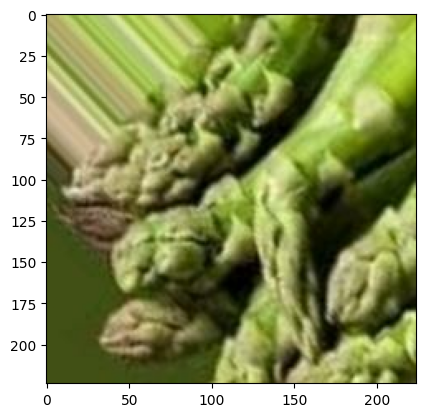

In [8]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None

for image, label in X_train:#.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
    
#if you want to see an image
print("test label:", test_label)
print("first test label:", test_label[0])
print("first test label human:", target_dict[test_label[0]])

plt.imshow(test_image[0]/255)
plt.title(target_dict[test_label[0]])

In [9]:
in_shape = test_image[0].shape
in_shape

num_classes = len(X_train.class_names)
print("num_classes: ", num_classes)
print("in_shape: "   , in_shape)

num_classes:  45
in_shape:  (224, 224, 3)


# Create model

In [10]:
#TODO try augmentatoin layers?

#declare model
def instantiate_model_thicc():
    model = models.Sequential()

    #normalise the inputs
    model.add(layers.Rescaling(1./255))

    #first convolutional layer - big kernels, few filters
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    #third conv layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Flatten
    model.add(layers.Flatten())

    #Dense layers - do we regularise the kernels?!
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    # model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    # model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    # model.add(layers.Dropout(0.2) )
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) ) 
    model.add(layers.Dense(8, activation="relu"))#, kernel_regularizer=reg_l1_l2))

    #Last layer, convert for appropriate model output
    model.add(layers.Dense(num_classes, activation="softmax"))
    #model.add(layers.Dense(num_classes, activation="softmax"))
    
    return model

#model = instantiate_model_thicc()

In [11]:
#declare model
def instantiate_model_old():
    model = models.Sequential()

    #normalise the inputs
    model.add(layers.Rescaling(1./255))

    #first convolutional layer - big kernels, few filters
    model.add(layers.Conv2D(16, kernel_size=(5,5), padding="same", activation="relu", input_shape=in_shape))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #third conv layer
    model.add(layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    #Flatten
    model.add(layers.Flatten())

    #Dense layers - do we regularise the kernels?!
    model.add(layers.Dense(64, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(32, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.3) )
    model.add(layers.Dense(16, activation="relu"))#, kernel_regularizer=reg_l1_l2))
    model.add(layers.Dropout(0.2) ) 

    #Last layer, convert for appropriate model output
    model.add(layers.Dense(num_classes, activation="softmax"))
    #model.add(layers.Dense(num_classes, activation="softmax"))
    
    return model

#model = instantiate_model()

In [12]:
#compile model
from tensorflow.keras import metrics as mets
def compile_model(model, learning_rate=0.001): #default0.001
    loss = "sparse_categorical_crossentropy"
    
    # loss = "categorical_crossentropy"
    optimizer = "adam"
    # optimizer = tensorflow.keras.optimizers.Adam(
    #     learning_rate=learning_rate
    # )
    
    #metrics = ["accuracy"]
    #metrics = [Precision(), Recall(), Accuracy()]
    #metrics = [Precision()]
    
    metrics = [mets.SparseCategoricalAccuracy(), "accuracy"] #??
    # metrics = [mets.CategoricalAccuracy()]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
#model = compile_model(model)
#model.__dict__;

In [13]:
def fit_model(model, patience=20, epochs=100):
    #prep for early stopping
        
    es = EarlyStopping(patience=patience, restore_best_weights=True)

    #fit
    history = model.fit(
            X_train, 
            validation_data=X_val, 
            epochs=epochs,
            #epochs=5,
            batch_size=16,
            callbacks=[es], 
            verbose=1
        )
    return history, model

#history, model = fit_model(model)

#if below error, RESTART KERNEL(s)!:
# 2023-03-08 16:05:03.024852: E tensorflow/stream_executor/cuda/cuda_dnn.cc:373] 
# Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR

## Saving model

In [14]:
#model_name = "simple_try_on_unaugmented_33_classes"
def save_model(model, model_name):
    path_to_models = os.path.join("..","..","models")
    os.makedirs(path_to_models, exist_ok=True) #True means don't create new dir if already exists #os.makedirs(path, exist_ok=True)

    if not model_name:
        print("please give the model a name! #goodpractice")
        print("model NOT saved")
        return None
    
    model_path = os.path.join(path_to_models, model_name)
    
    model.save(model_path)
    
    return f"model saved in {path_to_models} as {model_name}"

## track model



In [15]:
import pickle
def save_history(history, model_name):
    
    #model folder path
    model_path = os.path.join("..","..","models", model_name)
    path = os.path.join(model_path, "history")
    
    with open(path, 'wb') as history_file:
        pickle.dump(history, history_file)
    
    return None

def load_history(model_name):
    #model_name="test_folder"
    
    model_path = os.path.join("..", "..", "models", model_name) #, "test_folder")
    
    path = os.path.join(model_path, "history")
    
    with open(path, "rb") as history_file:
        history = pickle.load(history_file)

    return history

In [16]:
def plot_learning_curve(history):
    history.history;
    train_accuracy = history.history["sparse_categorical_accuracy"]
    val_accuracy = history.history["val_sparse_categorical_accuracy"]

    plt.plot(train_accuracy, label="train")
    plt.plot(val_accuracy,label="val")
    plt.legend()
    return None

# Run and save model!

Epoch 1/200
2853/2853 [==============================] - 260s 89ms/step - loss: 3.8072 - sparse_categorical_accuracy: 0.0212 - accuracy: 0.0212 - val_loss: 3.8065 - val_sparse_categorical_accuracy: 0.0224 - val_accuracy: 0.0224
Epoch 2/200
2853/2853 [==============================] - 258s 90ms/step - loss: 3.8072 - sparse_categorical_accuracy: 0.0222 - accuracy: 0.0222 - val_loss: 3.8066 - val_sparse_categorical_accuracy: 0.0224 - val_accuracy: 0.0224
Epoch 3/200
2853/2853 [==============================] - 256s 90ms/step - loss: 3.8072 - sparse_categorical_accuracy: 0.0224 - accuracy: 0.0224 - val_loss: 3.8066 - val_sparse_categorical_accuracy: 0.0224 - val_accuracy: 0.0224
Epoch 4/200
2853/2853 [==============================] - 254s 89ms/step - loss: 3.8072 - sparse_categorical_accuracy: 0.0217 - accuracy: 0.0217 - val_loss: 3.8066 - val_sparse_categorical_accuracy: 0.0224 - val_accuracy: 0.0224
Epoch 5/200
2853/2853 [==============================] - 254s 89ms/step - loss: 3.8072 -

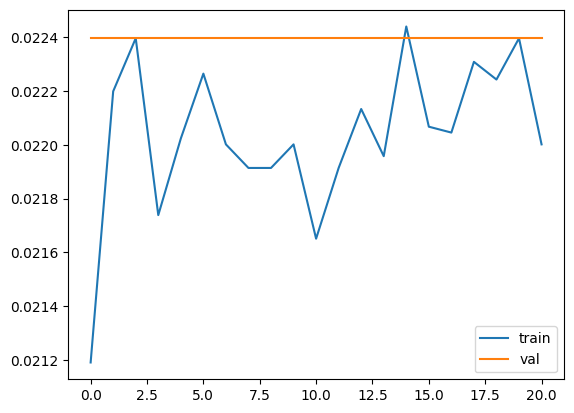

In [17]:
model_name = "sat_model_on_45_no_aug_slow_lr"
def run_and_save_model(model_name = ""):
    
    if not model_name:
        return "! You must give name."
    
    learning_rate= 0.001 # #default 0.001
    patience = 20
    epochs = 200
    
    model = instantiate_model_thicc()
    #model = instantiate_model_old()

    model = compile_model(model, learning_rate)
    
    history, model = fit_model(model, patience, epochs)
    model.summary()
    
    save_model(model, model_name)
    
    save_history(history, model_name)
    
    plot_learning_curve(history)
    
    return history, model
    
history, model = run_and_save_model(model_name)

In [18]:
#shall be too big
# def my_grid_search():
    
#     learning_rates = []
#     epochs = []
#     kernel_sizes = [] # 3,4,5 
#     kernel_stride = []
    
    
    

## Getting y out

In [19]:
#pull target out of tensorflow.dataset
#can do train test or val (seems that test is batches of 1?)
def get_y_from_X(X, batched=True):
    
    y_batched = []
    y = []
    
    for batch_image, batch_label in X:
        
        if batched:
            y_batched.append(batch_label.numpy())
        else:
            for image,label in zip(batch_image, batch_label):
                y.append(label.numpy())
     
    if batched:
        print("len y_batched", len(y_batched) )
        return y_batched
    else:
        print("len y", len(y))
        return y

In [20]:
count=0

for thing, label in X_test.take(1):
    if count == 0:
        print(label)
    count += 1


tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [21]:
def get_y_test(X_test_in):
    y_test = get_y_from_X(X_test_in, batched=False)
    return y_test
    
def get_y_pred(X_test_in):
    #gets array with probabilities
    # if model_name != None:
    #     print(f"getting predictions from {model_name}")
    # else:
    #     print(f"getting predictions from unnamed (probably not saved) 'model'")
        
    y_pred_0 = model.predict(X_test, verbose=1)
    y_pred = []
    
    for pred in y_pred_0:
        y_pred.append(pred.argmax())
        
    return y_pred


In [22]:
#get y_pred and y_true out of X_test, thanks to above funcs
y_pred = get_y_pred(X_test)
y_test = get_y_test(X_test)
path_to_dataset = os.path.join("..","..","data","food")
    
#path_to_dataset = os.path.join("..", "..", "test_data", "2_whole_data_some_dups")
    
path_to_dataset_train = os.path.join(path_to_dataset, "train")
y_pred;

576/576 [==============================] - 17s 29ms/step
len y 9209


In [23]:
path_to_dataset = os.path.join("..","..","data","food")
    
path_to_dataset_train = os.path.join(path_to_dataset, "train")

#path_to_dataset = os.path.join("..", "..", "test_data", "2_whole_data_some_dups")
    
# if new_way:
#     path_to_dataset_train = os.path.join(path_to_dataset, "train")
#     path_to_dataset_test = os.path.join(path_to_dataset,  "test")
#     path_to_dataset_val = os.path.join(path_to_dataset,   "validation")

In [24]:
def get_target_dict():
    if new_way:
        classes = os.listdir(path_to_dataset_train)
    else:
        classes = os.listdir(path_to_dataset)
    classes.sort()
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict

{0: 'apple',
 1: 'asparagus',
 2: 'avocado',
 3: 'banana',
 4: 'beef',
 5: 'beetroot',
 6: 'blueberry',
 7: 'broccoli',
 8: 'cabbage',
 9: 'capsicum',
 10: 'carrot',
 11: 'cauliflower',
 12: 'celery',
 13: 'chicken',
 14: 'coconut',
 15: 'cod',
 16: 'corn',
 17: 'cranberry',
 18: 'cucumber',
 19: 'eggplant',
 20: 'eggs',
 21: 'garlic',
 22: 'ginger',
 23: 'grape',
 24: 'honey',
 25: 'kiwi',
 26: 'leek',
 27: 'lemon',
 28: 'lettuce',
 29: 'lime',
 30: 'milk',
 31: 'mushroom',
 32: 'onion',
 33: 'orange',
 34: 'pineapple',
 35: 'pork',
 36: 'potato',
 37: 'prawns',
 38: 'pumpkin',
 39: 'salmon',
 40: 'spinach',
 41: 'strawberry',
 42: 'tomato',
 43: 'white_wine',
 44: 'zucchini'}

In [25]:
#can be useful to have them just as list
if new_way:
    classes_list = os.listdir(path_to_dataset_train)
else:
    classes_list = os.listdir(path_to_dataset)
classes_list.sort()
classes_list
classes_code = [i for i in range(len(classes_list))]
classes_code;

In [26]:
import pandas as pd
df = pd.DataFrame({"y_pred" : y_pred ,"y_test" : y_test})
df

,y_pred,y_test
0,28,0
1,28,0
2,28,0
3,28,0
4,28,0
...,...,...
9204,28,44
9205,28,44
9206,28,44
9207,28,44


## Looking at results

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes_list))

              precision    recall  f1-score   support

       apple       0.00      0.00      0.00       200
   asparagus       0.00      0.00      0.00       207
     avocado       0.00      0.00      0.00       200
      banana       0.00      0.00      0.00       200
        beef       0.00      0.00      0.00       208
    beetroot       0.00      0.00      0.00       209
   blueberry       0.00      0.00      0.00       200
    broccoli       0.00      0.00      0.00       200
     cabbage       0.00      0.00      0.00       200
    capsicum       0.00      0.00      0.00       200
      carrot       0.00      0.00      0.00       200
 cauliflower       0.00      0.00      0.00       200
      celery       0.00      0.00      0.00       203
     chicken       0.00      0.00      0.00       208
     coconut       0.00      0.00      0.00       200
         cod       0.00      0.00      0.00       204
        corn       0.00      0.00      0.00       210
   cranberry       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


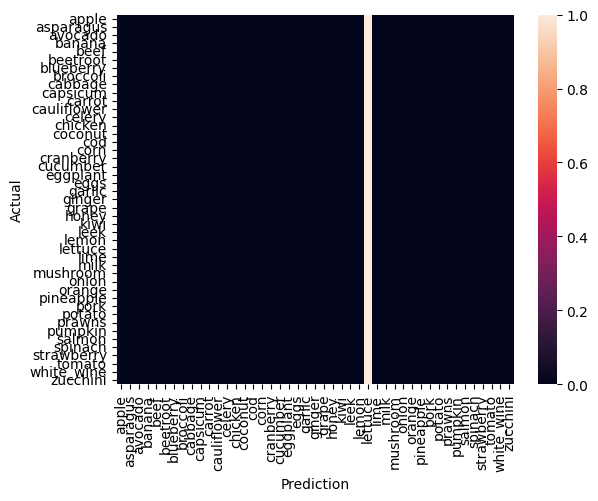

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true') #true as in truth
s = sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)
s.set(ylabel="Actual", xlabel="Prediction");

# EXPERIMENTATION

will move the good stuff above

#idea 
create random prediction func that we can run and inspect incorrect predictions?

In [29]:
from sklearn.metrics import classification_report

In [30]:
out = classification_report(y_test, y_pred, output_dict=True)
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix
#out

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
num_test = tf.data.experimental.cardinality(X_test)
num_test.numpy()

576

In [32]:
y_pred = model.predict(X_test, verbose=1)

576/576 [==============================] - 16s 28ms/step


In [33]:
num_test = tf.data.experimental.cardinality(X_test.take(1))
num_test.numpy()

1

In [34]:
out = classification_report(y_true, y_pred, output_dict=True)

NameError: name 'y_true' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
cm = confusion_matrix(y_test,y_pred, labels=classes_code , normalize='true')

# cm_df = pd.DataFrame(cm,
#                      index = target_dict.values(), 
#                      columns = target_dict.values())

sns.heatmap(cm,xticklabels=classes_list, yticklabels=classes_list)

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
#https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
#https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/MultiLabelConfusionMatrix

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes_list))

In [ ]:
classes_list

In [ ]:
out

In [ ]:
#out

pred_comparison_limit = 10
count=0
for y_t, y_p in zip(y_true , y_pred):
    print(f"true: {y_t}  pred:{y_p}")
    count+=1
    
    if count > pred_comparison_limit:
        break

In [ ]:
#get labels from folders, must be done in 2 lines...
classes = os.listdir(path_to_dataset_train)
classes.sort()

In [ ]:
target_dict = {}
for index,classs in enumerate(classes):
    target_dict[index] = classs
    
print(target_dict.values())

In [ ]:
path_to_dataset

In [ ]:
#get one image - I wish I knew a better way
count = 0
test_image, test_label = None, None
for image, label in X_test.take(1):
    if count == 0 :
        test_image = image.numpy()
        test_label = label.numpy()
    count+=1
    if count > 0: break
#if you want to see an image
print(test_label[0])
plt.imshow(test_image[0]/255)

In [ ]:
model.evaluate(X_test, return_dict=True)

In [ ]:
history.history;
train_accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]

plt.plot(train_accuracy, label="train")
plt.plot(val_accuracy,label="val")
plt.legend()

In [ ]:
def get_target_dict():
    if new_way:
        classes = os.listdir(path_to_dataset_train)
    else:
        classes = os.listdir(path_to_dataset)
    classes.sort()
    
    target_dict_out = {}
    for index, veg in enumerate(classes):
        target_dict_out[index] = veg
    
    return target_dict_out
target_dict = get_target_dict()
target_dict



In [ ]:
import pandas as pd
df = pd.DataFrame({"y_pred" : y_pred ,"y_test" : y_test})
df
#plot some incorrect guesses

#look through y_true and y_pred and save indexes + correct incorrect

#make df of index, class word, class enum (y_test) , y_pred (word), y_pred 

def get_word_from_encode(list_in):
    list_out = []
    translator_dict = get_target_dict()
    
    for code in list_in:
        list_out.append(translator_dict[code])
    
    return list_out

#y_pred_word = get_word_from_encode(y_pred)
#y_test_word = get_word_from_encode(y_test)

